## Schachbrett-Ecken erkennen

**Option A:** `findChessboardCorners` – findet die inneren Ecken des Musters; die 4 äußeren Ecken ergeben sich aus den Randpunkten.  
**Option B:** Harris-Corners auf dem Kantenbild – allgemeine Eckendetektion, dann die 4 äußersten Ecken wählen (z.B. konvexe Hülle / Extrempunkte).

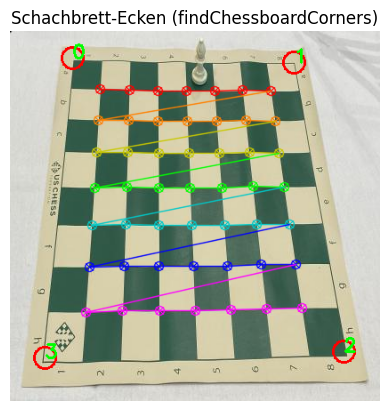

In [ ]:
# Bild nochmal laden (Farbe für Ausgabe)
img_bgr = cv2.imread('board-data/test/images/0b47311f426ff926578c9d738d683e76_jpg.rf.40183eae584a653181bbd795ba3c353f.jpg')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# --- Option A: OpenCV Schachbrett-Detektor (8x8 = 7x7 innere Ecken) ---
pattern_size = (7, 7)  # innere Ecken (zwischen den Feldern)
found, corners = cv2.findChessboardCorners(img_gray, pattern_size)

if found:
    # Subpixel-Verfeinerung
    corners = cv2.cornerSubPix(img_gray, corners, (5, 5), (-1, -1),
                               (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
    # Echte Brett-Ecken: vom inneren Gitter um 1 Feld nach außen extrapolieren
    h, w = pattern_size[1], pattern_size[0]
    grid = corners.reshape(h, w, 2)
    def extrapolate(pt, step_left, step_up):
        return pt + (pt - step_left) + (pt - step_up)
    outer_tl = extrapolate(grid[0, 0],  grid[0, 1],  grid[1, 0])   # oben links
    outer_tr = extrapolate(grid[0, -1], grid[0, -2], grid[1, -1])   # oben rechts
    outer_bl = extrapolate(grid[-1, 0], grid[-1, 1], grid[-2, 0])   # unten links
    outer_br = extrapolate(grid[-1, -1], grid[-1, -2], grid[-2, -1]) # unten rechts
    outer_corners = np.array([outer_tl, outer_tr, outer_br, outer_bl], dtype=np.float32)
    
    out = img_bgr.copy()
    cv2.drawChessboardCorners(out, pattern_size, corners, found)
    for i, p in enumerate(outer_corners):
        pt = tuple(p.astype(int))
        cv2.circle(out, pt, 12, (0, 0, 255), 2)
        cv2.putText(out, str(i), pt, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    # In Jupyter anzeigen statt cv2.imshow:
    from matplotlib import pyplot as plt
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Schachbrett-Ecken (findChessboardCorners)')
    plt.show()
else:
    print("Schachbrett-Muster nicht gefunden – prüfe pattern_size oder Bildausschnitt.")

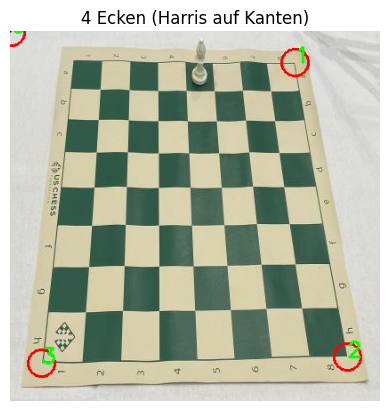

In [17]:
# --- Option B: Harris-Ecken auf dem Kantenbild (wenn findChessboardCorners versagt) ---
sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
edges = cv2.convertScaleAbs(cv2.magnitude(sobelx, sobely))

# Harris-Corners
harris = cv2.cornerHarris(edges, blockSize=3, ksize=3, k=0.04)
harris_norm = np.uint8(255 * (harris - harris.min()) / (harris.max() - harris.min() + 1e-8))

# Starke Ecken (Threshold)
thresh = 0.25 * harris.max()
y, x = np.where(harris > thresh)
points = np.column_stack((x, y))

# Die 4 äußeren Ecken: Punkte mit min/max von (x+y) und (x-y) → 4 Extrempunkte
if len(points) >= 4:
    center = points.mean(axis=0)
    s1 = points[:, 0] + points[:, 1]   # „oben-links“ vs „unten-rechts“
    s2 = points[:, 0] - points[:, 1]   # „oben-rechts“ vs „unten-links“
    idx_tl = np.argmin(s1)
    idx_br = np.argmax(s1)
    idx_tr = np.argmax(s2)
    idx_bl = np.argmin(s2)
    outer = np.array([points[idx_tl], points[idx_tr], points[idx_br], points[idx_bl]])
    
    out2 = img_bgr.copy()
    for i, p in enumerate(outer):
        pt = tuple(p.astype(int))
        cv2.circle(out2, pt, 15, (0, 0, 255), 2)
        cv2.putText(out2, str(i), pt, cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    from matplotlib import pyplot as plt
    plt.imshow(cv2.cvtColor(out2, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('4 Ecken (Harris auf Kanten)')
    plt.show()
else:
    print("Zu wenige Harris-Ecken – Threshold anpassen oder Bild prüfen.")